# Yaw angle optimisation
Calculating the optimum yaw angle for turbines across a range of wakes and wind speeds

## To do
- Choose optimisation method
    - Speed
    - Convergence criteria control
- Increase fidelity
    - Assess difference in speed of calculation and optimal values
- Loop over wind direction
    - Parallelise using PQDM
- Assess results
    - Sensitivity to wind direction/speed
    - Variation in sensitivity between turbines
    - Increase number of turbines

## Setup

In [1]:
# import libraries
import logging

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy import optimize
from tqdm.notebook import tqdm

import utils

In [2]:
# define constants
yaw_scale = 30

## Baseline values

In [3]:
# run baseline simulation
sim_res_base = utils.run_sim()

In [4]:
# cut in speed
cut_in_index = np.argmax(
    sim_res_base.windFarmModel.windTurbines.power(sim_res_base.ws) > 0
)
cut_in_speed = sim_res_base.ws[cut_in_index].values.tolist()

In [5]:
# ensure probabilities (wind direction and speed) total 1
Sector_frequency = sim_res_base.Sector_frequency
if not np.isclose(Sector_frequency.sum(), 1):
    logging.warning(
        f"Sector frequency renormalised as total probability was {Sector_frequency.sum().values}"
    )
    Sector_frequency = Sector_frequency / Sector_frequency.sum()
P = sim_res_base.P
if not np.isclose(P.sum(), 1):
    logging.warning(f"P renormalised as total probability was {P.sum().values}")
    P = P / P.sum()

In [6]:
# calculate baseline metrics
aep_base, lcoe_base, cap_fac_base = utils.calc_metrics(
    sim_res=sim_res_base,
    sim_res_base=sim_res_base,
    Sector_frequency=Sector_frequency,
    P=P,
    show=True,
)
(
    lcoe_direction_base,
    cap_fac_direction_base,
    lcoe_overall_base,
    cap_fac_overall_base,
) = utils.aggregate_metrics(
    aep=aep_base,
    lcoe=lcoe_base,
    cap_fac=cap_fac_base,
    Sector_frequency=Sector_frequency,
)

AEP [GWh]: 79.174
LCoE [USD/MWh]: 44.477
Capacity factor [%]: 50.177


## Optimise across for a single wind direction

In [7]:
# define constants
wd = 270
yaw_shape = (len(sim_res_base.wt), 1, len(sim_res_base.ws))

In [8]:
# initialise optimal yaw dataset
yaw_opt = xr.Dataset(
    data_vars={
        "lcoe": (["wt", "wd", "ws"], np.zeros(yaw_shape)),
        "power": (["wt", "wd", "ws"], np.zeros(yaw_shape)),
    },
    coords={
        "wt": list(sim_res_base.wt.values),
        "wd": [wd],
        "ws": list(sim_res_base.ws.values),
    },
)

In [9]:
# optimise for power output indepedently across wind speeds
next_x0 = np.ones(len(sim_res_base.wt)) / yaw_scale
for ws in tqdm(sim_res_base.ws.values):
    if ws >= cut_in_speed:
        # define objective function for power
        def obj_power_single(yaw_norm):
            sim_res = utils.run_sim(yaw=yaw_norm * yaw_scale, ws=ws, wd=wd)
            obj = -(
                sim_res.Power.sel(ws=ws, wd=wd).sum("wt")
                / sim_res_base.Power.sel(ws=ws, wd=wd).sum("wt")
            ).values.tolist()
            return obj

        assert np.isclose(obj_power_single(np.zeros(len(sim_res_base.wt))), -1)
        # optimise power output
        res = optimize.minimize(fun=obj_power_single, x0=next_x0)
        # process results
        next_x0 = res.x
        yaw_opt.power.loc[:, wd, ws] = res.x * yaw_scale

  0%|          | 0/31 [00:00<?, ?it/s]

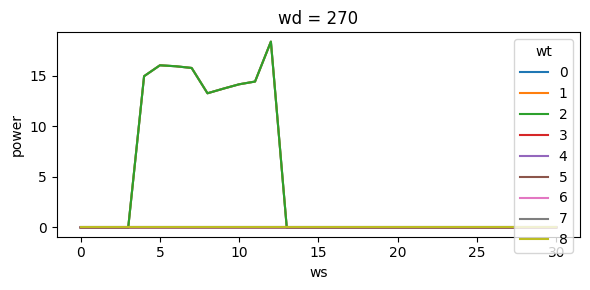

In [10]:
# plot optimum yaw angles based on power
fig, ax = plt.subplots(figsize=(6, 3))
yaw_opt.power.sel(wd=wd).plot.line(hue="wt")
fig.tight_layout()

In [11]:
# define objective function for lcoe
def obj_lcoe_single(yaw_norm):
    sim_res = utils.run_sim(yaw=yaw_norm.reshape(yaw_shape) * yaw_scale, wd=wd)
    aep, lcoe, _ = utils.calc_metrics(
        sim_res=sim_res,
        sim_res_base=sim_res_base,
        Sector_frequency=Sector_frequency,
        P=P,
    )
    _, _, lcoe_overall, _ = utils.aggregate_metrics(
        aep=aep, lcoe=lcoe, Sector_frequency=Sector_frequency
    )
    obj = (lcoe_overall / lcoe_direction_base.sel(wd=wd)).values.tolist()
    return obj


assert np.isclose(obj_lcoe_single(np.zeros(yaw_shape).ravel()), 1)

In [12]:
# define optimisation callback
def _callback(intermediate_result):
    global n
    if n % 5 == 0:
        print(f"Iteration {n:3.0f}: obj = {intermediate_result.fun:.5f}")
    n += 1

In [13]:
# run optimisation with iteration counter display
n = 0
res = optimize.minimize(
    fun=obj_lcoe_single, x0=yaw_opt.power.values.ravel() / yaw_scale, callback=_callback
)
yaw_opt.lcoe.loc[:, :, :] = res.x.reshape(yaw_shape) * yaw_scale
res

Iteration   0: obj = 0.99227
Iteration   5: obj = 0.99226


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.9922639877072307
        x: [ 0.000e+00  0.000e+00 ... -7.702e-09 -7.702e-09]
      nit: 8
      jac: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
 hess_inv: [[ 1.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            [ 0.000e+00  1.000e+00 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 3920
     njev: 14

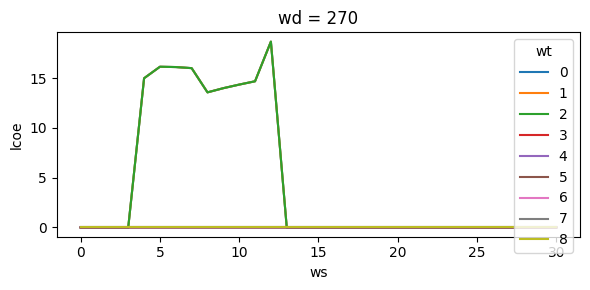

In [14]:
# plot optimum yaw angles
fig, ax = plt.subplots(figsize=(6, 3))
yaw_opt.lcoe.sel(wd=wd).plot.line(hue="wt")
fig.tight_layout()

In [15]:
# rerun simulation for optimum
sim_res_opt = utils.run_sim(yaw=yaw_opt.lcoe.values.reshape(yaw_shape), wd=wd)
aep_opt, lcoe_opt, cap_fac_opt = utils.calc_metrics(
    sim_res=sim_res_opt,
    sim_res_base=sim_res_base,
    Sector_frequency=Sector_frequency,
    P=P,
)
_, _, lcoe_overall_opt, cap_fac_overall_opt = utils.aggregate_metrics(
    aep=aep_opt, lcoe=lcoe_opt, cap_fac=cap_fac_opt, Sector_frequency=Sector_frequency
)

In [16]:
# display comaprison of optimum to baseline
print(f"Baseline LCoE [USD/MWh]      : {lcoe_direction_base.sel(wd=wd).values:.3f}")
print(f"Optimum LCoE [USD/MWh]       : {lcoe_overall_opt.values:.3f}")
print(
    f"Baseline Capacity Factor [%] : {100*cap_fac_direction_base.sel(wd=wd).values:.3f}"
)
print(f"Optimum Capacity Factor [%]  : {100*cap_fac_overall_opt.values:.3f}")

Baseline LCoE [USD/MWh]      : 43.252
Optimum LCoE [USD/MWh]       : 42.918
Baseline Capacity Factor [%] : 51.598
Optimum Capacity Factor [%]  : 52.001
